In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import OrderedDict
import pickle

In this notebook we will fine tune a GRU (http://arxiv.org/abs/1406.1078) based model to classify the protein domain given it's amino acid sequence.

The data comes from https://www.kaggle.com/datasets/googleai/pfam-seed-random-split which was proposed by Bileschi et al. (https://www.biorxiv.org/content/10.1101/626507v2.full)

In [132]:
def load_df_split(dir):
    df_list = []
    files = os.listdir(dir)
    for file in files:
        if file.startswith('data-'):
            df = pd.read_csv(os.path.join(dir, file))
            df_list.append(df)
    return pd.concat(df_list)

train_df = load_df_split('../random_split/train')
dev_df = load_df_split('../random_split/dev')
test_df = load_df_split('../random_split/test')

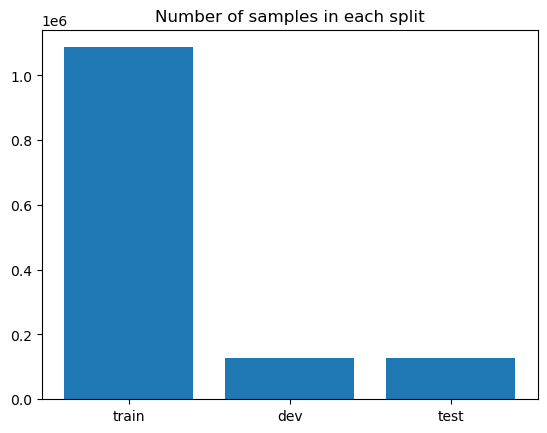

In [133]:
plt.bar(['train', 'dev', 'test'], [len(train_df), len(dev_df), len(test_df)])
plt.title('Number of samples in each split')
plt.show()
# -> roughly 80% train, 10% dev, 10% test
# -> we don't aim to do zero shot learning here so we exclude
# all the domains with less than 10 samples

In [134]:
# to do some dataset analysis, we combine the splits
combined_df = pd.concat([train_df, dev_df, test_df])

In [135]:
combined_df

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,Penicillinase_R,Q81U16_BACAN/8-123,PF03965.16,ISEAELEIMKVLWLKSP.QTANEIIEE.LEDP.MDW..KPKTIRTL...,ISEAELEIMKVLWLKSPQTANEIIEELEDPMDWKPKTIRTLINRLV...
1,Rtt106,POB3_CANAL/362-454,PF08512.12,AGVPCSVKA...SEGYLFPL......DRCFLF.VTKPTLYIPYSE....,AGVPCSVKASEGYLFPLDRCFLFVTKPTLYIPYSEISSVVMSRTGG...
2,F-actin_cap_A,Q8I3I2_PLAF7/12-301,PF01267.17,IRHVLMNSPPGKLYDLVK..DINILL.G.........SSVSIQ.KI...,IRHVLMNSPPGKLYDLVKDINILLGSSVSIQKILEEVLKDYNEKNY...
3,HupF_HypC,O28902_ARCFU/1-65,PF01455.18,MCIAIPGR...I.ER..IDY...............P....IAIVDF...,MCIAIPGRIERIDYPIAIVDFKGLKKEVRIDLLENPQIGDYVLVHV...
4,DUF3794,R6BY75_9CLOT/189-271,PF12673.7,NIFHI..LWEDVDL..E.GVTFKPMG...E...........S.......,NIFHILWEDVDLEGVTFKPMGESISVQGDIHIFVLYEGEGENTPIR...
...,...,...,...,...,...
12751,C1-set,IGHG2_CAVPO/229-315,PF07654.15,VYTLPPSRDE.LS.KSKVSVTCLIINFFP..ADIHVEWASNRVPVS...,VYTLPPSRDELSKSKVSVTCLIINFFPADIHVEWASNRVPVSEKEY...
12752,Cofac_haem_bdg,F0LPX5_VIBFN/30-233,PF04187.13,FRHAIRHADVILVGEWH..THTGIHRFQTDLLQTL..............,FRHAIRHADVILVGEWHTHTGIHRFQTDLLQTLSQEERPVALSMEQ...
12753,S-methyl_trans,A1B3D4_PARDP/21-337,PF02574.16,LI.....................LDGAMGTQI.Q....QL.........,LILDGAMGTQIQQLGLSETDFAGHGTGCACGCHPPAPGEHPQQGNN...
12754,Glyco_trans_1_4,B8FJ84_DESAA/245-385,PF13692.6,KNRLLVTN...SA.DT.....PLKGL.YHL..LKAV.HEVR....K...,KNRLLVTNSADTPLKGLYHLLKAVHEVRKKRDVTLTVIGAPKKHGG...


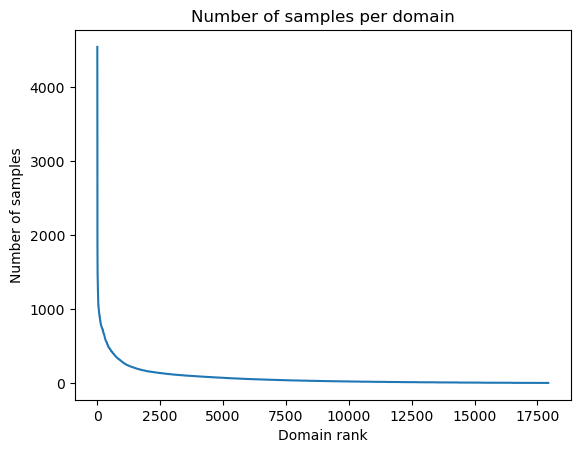

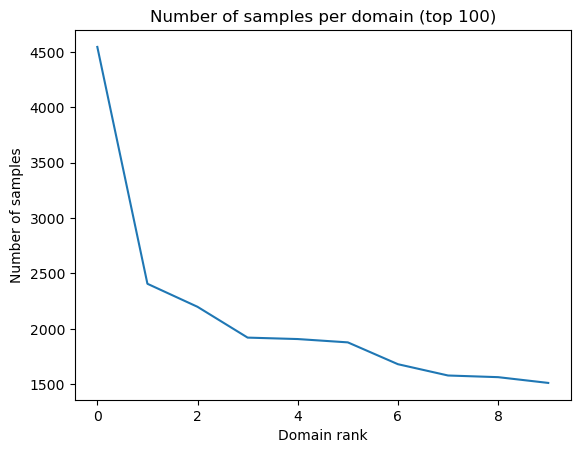

In [136]:
# count number of samples per domain
domain_counts = combined_df.groupby('family_accession').count()['sequence'].sort_values(ascending=False).values

plt.plot(domain_counts)
plt.title('Number of samples per domain')
plt.xlabel('Domain rank')
plt.ylabel('Number of samples')
plt.show()

plt.plot(domain_counts[:10])
plt.title('Number of samples per domain (top 100)')
plt.xlabel('Domain rank')
plt.ylabel('Number of samples')
plt.show()

# we can see that the number of samples per domain is very skewed

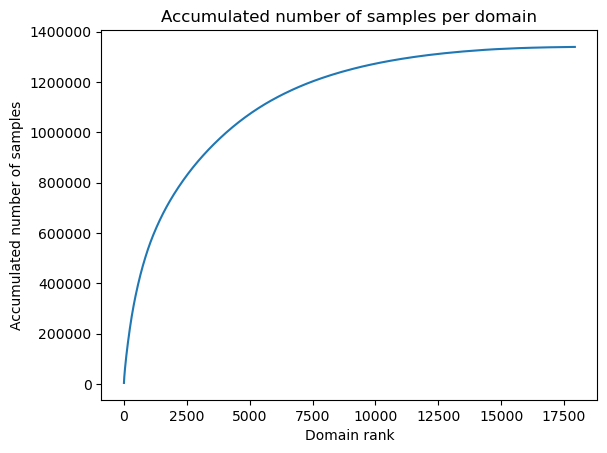

In [145]:
accumulated_counts = np.cumsum(domain_counts)
plt.plot(accumulated_counts)
plt.ticklabel_format(style='plain')
plt.title('Accumulated number of samples per domain')
plt.xlabel('Domain rank')
plt.ylabel('Accumulated number of samples')
plt.show()

Now we have a problem, there are over 17000 classes.That means the last layer of our model will have 17000 * embedding_depth parameters.

This will be too much for the 4GB GPU requirement. In a real work scenario, we could try to either combine labels or be very smart about the architecture.

But for this notebook, we will just take domains with at least 200 sequences. This will reduce the number of classes to less than 1500.

In [146]:
# filter out domains with less than 200 samples
filtered_family_accessions = combined_df.groupby('family_accession').filter(lambda x: len(x) >= 200)['family_accession'].unique()
combined_df = combined_df[combined_df['family_accession'].isin(filtered_family_accessions)]

In [152]:
domain_counts_filtered = combined_df.groupby('family_accession').count()['sequence'].sort_values(ascending=False).values

print(domain_counts.sum() - domain_counts_filtered.sum(), 'samples removed')
print('Number of Domains removed: {} ({:.2f}%)'.format(len(domain_counts) - len(domain_counts_filtered), (len(domain_counts) - len(domain_counts_filtered)) / len(domain_counts) * 100))
print('Number of samples remaining: {} ({:.2f}%)'.format(len(combined_df), len(combined_df) / len(train_df) * 100))
print('Number of domains remaining: {} ({:.2f}%)'.format(len(domain_counts_filtered), len(domain_counts_filtered) / len(domain_counts) * 100))

668048 samples removed
Number of Domains removed: 16406 (91.51%)
Number of samples remaining: 671035 (61.75%)
Number of domains remaining: 1523 (8.49%)


Filtering the data results in 1523 (8.5%) domains, that contain 61% of the sequences.


The next question is about the sequence length of the domains.

As we can see below, roughly 80% of the sequences have less than 200 amino acids. To keep the model training fast and memory light, we will truncate sequences later to 200 amino acids.

In [153]:
# we only keep the domains with at least 10 samples
train_df = train_df[train_df["family_accession"].isin(filtered_family_accessions)]
dev_df = dev_df[dev_df["family_accession"].isin(filtered_family_accessions)]
test_df = test_df[test_df["family_accession"].isin(filtered_family_accessions)]

/var/folders/ft/4cmbwrdn1yzcq31nl6sw0sxr0000gn/T/ipykernel_4387/1118487581.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Dark2')


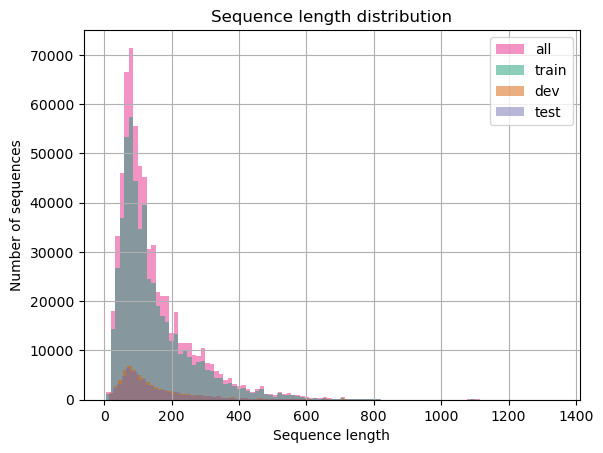

In [154]:
# Q: how can I use Dark2 to color the domains?
# A: https://stackoverflow.com/questions/18926031/how-to-extract-colors-from-matplotlib-colormap
from matplotlib import cm
cmap = cm.get_cmap('Dark2')


seq_lens = combined_df['sequence'].apply(lambda x: len(x))
seq_lens_train = train_df['sequence'].apply(lambda x: len(x))
seq_lens_dev = dev_df['sequence'].apply(lambda x: len(x))
seq_lens_test = test_df['sequence'].apply(lambda x: len(x))
seq_lens.hist(bins=100, alpha=0.5, label='all', color=cmap(3))
seq_lens_train.hist(bins=100, alpha=0.5, label='train', color=cmap(0))
seq_lens_dev.hist(bins=100, alpha=0.5, label='dev', color=cmap(1))
seq_lens_test.hist(bins=100, alpha=0.5, label='test', color=cmap(2))
plt.title('Sequence length distribution')
plt.xlabel('Sequence length')
plt.ylabel('Number of sequences')
plt.legend()
plt.show()
# -> most of the sequences are less than 500 amino acids long

In [158]:
# compute percentiles
percentiles = [0, 25, 50, 75, 80, 90, 95, 99, 100]
print('Percentiles:')
print(" ".join(str(x) for x in percentiles))
print('all:', np.percentile(seq_lens, percentiles))
print('train:', np.percentile(seq_lens_train, percentiles))
print('dev:', np.percentile(seq_lens_dev, percentiles))
print('test:', np.percentile(seq_lens_test, percentiles))

Percentiles:
0 25 50 75 80 90 95 99 100
all: [   6.   73.  112.  188.  216.  298.  377.  556. 1344.]
train: [   6.   73.  112.  188.  216.  298.  377.  556. 1340.]
dev: [  15.   73.  112.  188.  216.  298.  377.  555. 1344.]
test: [  15.   73.  112.  188.  216.  299.  377.  559. 1230.]


In [15]:
# lets truncate the sequences to 200 amino acids
max_seq_len = 200
combined_df['sequence'] = combined_df['sequence'].apply(lambda x: x[:max_seq_len])
train_df['sequence'] = train_df['sequence'].apply(lambda x: x[:max_seq_len])
dev_df['sequence'] = dev_df['sequence'].apply(lambda x: x[:max_seq_len])
test_df['sequence'] = test_df['sequence'].apply(lambda x: x[:max_seq_len])

/tmp/ipykernel_11866/3635853205.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['sequence'] = combined_df['sequence'].apply(lambda x: x[:max_seq_len])


In [17]:
# save the dataframes
combined_df.to_csv('../data/combined.tsv', sep='\t', index=False)
train_df.to_csv('../data/train.tsv', sep='\t', index=False)
dev_df.to_csv('../data/dev.tsv', sep='\t', index=False)
test_df.to_csv('../data/test.tsv', sep='\t', index=False)

We are going to sanity check the amino acid distribution of the sequences and build our vocabulary based on that.

We are going to assign each amino acid an ID and use that to build our embedding layer. I would have loved to use a pretrained language model but they weren't small enough to fit in the GPU memory generally and I didnt want to spend too much time on that if we already triaged the classes and sequence lengths.

In [18]:
amino_acids_counts = OrderedDict()
i = 0
for seq in combined_df['sequence']:
    for aa in seq:
        if aa in amino_acids_counts:
            amino_acids_counts[aa] += 1
        else:
            amino_acids_counts[aa] = 1

In [19]:
# sort by count
amino_acids_counts = OrderedDict(sorted(amino_acids_counts.items(), key=lambda x: x[1], reverse=True))

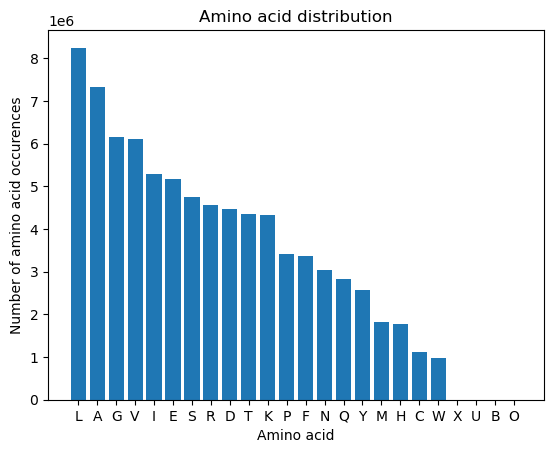

In [20]:
plt.bar(amino_acids_counts.keys(), amino_acids_counts.values())
plt.title('Amino acid distribution')
plt.xlabel('Amino acid')
plt.ylabel('Number of amino acid occurences')
plt.show()

In [21]:
tokenizer_dict = {}
special_aa = ['B', 'U', 'Z', 'O', 'X']
for idx, aa in enumerate(amino_acids_counts):
    if aa in special_aa:
        tokenizer_dict[aa] = 0
    else:
        tokenizer_dict[aa] = idx + 1

pickle.dump(tokenizer_dict, open('../data/tokenizer_dict.pkl', 'wb'))

tokenizer_dict

{'L': 1,
 'A': 2,
 'G': 3,
 'V': 4,
 'I': 5,
 'E': 6,
 'S': 7,
 'R': 8,
 'D': 9,
 'T': 10,
 'K': 11,
 'P': 12,
 'F': 13,
 'N': 14,
 'Q': 15,
 'Y': 16,
 'M': 17,
 'H': 18,
 'C': 19,
 'W': 20,
 'X': 0,
 'U': 0,
 'B': 0,
 'O': 0}

# Train models

Now we train the model. We are going to use an embedding (512 dimensions) layer followed by a single layer bidirectional GRU (120 dimensional hidden state) and 1 dense output layer (120 * nr_classes). We are going to use a dropout of 0.1 after the recurrent layer.


I chose GRU because it is faster and more lightweight than LSTM (https://ieeexplore.ieee.org/abstract/document/6795963) and fits the problem well. I benchmarked LSTM, DAN (https://people.cs.umass.edu/~miyyer/pubs/2015_acl_dan.pdf), a shallow transformer encoder. The GRU performed best. I didnt include the benchmarking code here because it would complicate the notebook but it is basically the same as the training code below with different models.

Further I implemented a pytorch Dataset to manage our data, one-hot encodes the labels and truncates/pads the sequences to 200 amino acids.
Also, there are train and eval loops that do the model calls and loss backpropagation with pytorchs autograd.

## dataset and model classes

In [31]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from einops import rearrange


class GRUNet(torch.nn.Module):
    def __init__(self, num_embeddings,output_dim, embedding_dim=128, hidden_size=128, layer_num=1, dropout=0.1, bidirectional=False, return_embedding=False):
        super(GRUNet, self).__init__()
        self.return_embedding = return_embedding
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.embedding = torch.nn.Embedding(
            num_embeddings=self.num_embeddings,
            embedding_dim=self.embedding_dim
            )
        self.gru = torch.nn.GRU(
            input_size=self.embedding_dim,
            hidden_size=hidden_size,
            num_layers=layer_num,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=True
            )
        num_gru_out_features = hidden_size if bidirectional == False else hidden_size * 2
        self.output_head = torch.nn.Linear(
            in_features=num_gru_out_features,
            out_features=output_dim
            )
        self.activation = torch.nn.ELU()
    
    def forward(self, x):
        x = self.embedding(x)
        _, hn = self.gru(x)
        hn = rearrange(hn, 'd b h -> b (d h)')
        x = self.output_head(hn)
        x = self.activation(x)
        if self.return_embedding:
            return x, hn
        return x



def collate_fn(batch):
    batch = list(zip(*batch))
    seqs = torch.nn.utils.rnn.pad_sequence(batch[0], batch_first=True)
    labels = torch.tensor(np.array(batch[1]), dtype=torch.float16)
    return seqs, labels

class ProteinDataSet(Dataset):
    def __init__(self, sequences, labels, tokenizer_dict, one_hot_encoder, max_seq_len=500):
        print('Initializing ProteinDataSet')
        self.sequences = sequences
        self.labels = labels
        self.max_seq_len = max_seq_len
        self.tokenizer_dict = tokenizer_dict
        self.tokenized_seqs = [torch.tensor([self.tokenizer_dict[aa] for aa in seq[:self.max_seq_len]]) for seq in self.sequences]

        self.one_hot_encoder = one_hot_encoder

        self.one_hot_encoded_labels = self.one_hot_encoder.transform(np.array(self.labels).reshape(-1, 1))
        print('Finished initializing ProteinDataSet')

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        tokenized_seq = self.tokenized_seqs[idx]
        label = self.one_hot_encoded_labels[idx].toarray().squeeze()
        return tokenized_seq, label

def train_loop(model, train_loader, optimizer, loss_fn, epoch, device):
    model.train().to(device)
    train_loss = 0
    running_accuracy = 0
    for batch_idx, (seq, label) in enumerate(train_loader):
        if batch_idx % 1000 == 0:
            print('Epoch: {}, Batch: {} of {}, Accuracy: {:.2f}'.format(epoch, batch_idx, len(train_loader), running_accuracy/(batch_idx + 1)))
        seq = seq.to(device)
        label = label.squeeze().to(device)
        optimizer.zero_grad()
        output = model(seq)
        loss = loss_fn(output, label)
        #print(loss)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = torch.argmax(output, dim=1)
        ground_truth_batch = torch.argmax(label, dim=1)
        running_accuracy += accuracy_score(ground_truth_batch.cpu(), preds.cpu())
    train_loss /= len(train_loader)
    running_accuracy /= len(train_loader)
    print('Epoch: {}, Training Loss: {}'.format(epoch, train_loss))
    return train_loss, running_accuracy

def eval_loop(model, dev_loader, loss_fn, epoch, device, return_predictions=False):
    all_preds = []
    all_ground_truths = []
    model.eval().to(device)
    eval_loss = 0
    with torch.no_grad():
        for batch_idx, (seq, label) in enumerate(dev_loader):
            seq = seq.to(device)
            label = label.squeeze().to(device)
            output = model(seq)
            loss = loss_fn(output, label)

            preds = torch.argmax(output, dim=1)
            ground_truth_batch = torch.argmax(label, dim=1)
            for pred in preds:
                all_preds.append(pred.item())
            for ground_truth in ground_truth_batch:
                all_ground_truths.append(ground_truth.item())
            
            eval_loss += loss.item()
    eval_loss /= len(dev_loader)
    acc = accuracy_score(all_ground_truths, all_preds)
    print('Epoch: {}, Validation Loss: {}, Accuracy Score: {}'.format(epoch, eval_loss, acc))
    
    if return_predictions:
        return eval_loss, acc, all_preds, all_ground_truths
    return eval_loss, acc

def train_model(model, train_loader, dev_loader, device, save_path, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.CrossEntropyLoss()
    train_losses = []
    dev_losses = []
    train_accs = []
    dev_accs = []
    for epoch in range(epochs):
        curr_best_accuracy = 0
        train_loss, train_acc = train_loop(model, train_loader, optimizer, loss_fn, epoch, device)
        dev_loss , dev_acc = eval_loop(model, dev_loader, loss_fn, epoch, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        dev_losses.append(dev_loss)
        dev_accs.append(dev_acc)
        
        if dev_acc > curr_best_accuracy:
            curr_best_accuracy = dev_acc
            torch.save(model.state_dict(), save_path)
    
    return train_losses, train_accs, dev_losses, dev_accs
    

## do model training

In [32]:
from sklearn.preprocessing import OneHotEncoder

tokenizer_dict = pickle.load(open('../data/tokenizer_dict.pkl', 'rb'))
combined_df = pd.read_csv('../data/combined.tsv', sep='\t')

encoder = OneHotEncoder()
encoder.fit(combined_df['family_accession'].values.reshape(-1, 1))


train_df = pd.read_csv('../data/train.tsv', sep='\t')
train_seqs = train_df['sequence'].values
train_labels = train_df['family_accession'].values
train = ProteinDataSet(train_seqs, train_labels, tokenizer_dict, one_hot_encoder=encoder, max_seq_len=200)

dev_df = pd.read_csv('../data/dev.tsv', sep='\t')
dev_seqs = dev_df['sequence'].values
dev_labels = dev_df['family_accession'].values
dev = ProteinDataSet(dev_seqs, dev_labels, tokenizer_dict, one_hot_encoder=encoder, max_seq_len=200)

test_df = pd.read_csv('../data/test.tsv', sep='\t')
test_seqs = test_df['sequence'].values
test_labels = test_df['family_accession'].values
test = ProteinDataSet(test_seqs, test_labels, tokenizer_dict, one_hot_encoder=encoder, max_seq_len=200)

train_loader = DataLoader(train, batch_size=256, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev, batch_size=256, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test, batch_size=256, shuffle=True, collate_fn=collate_fn)

Initializing ProteinDataSet
Finished initializing ProteinDataSet
Initializing ProteinDataSet
Finished initializing ProteinDataSet
Initializing ProteinDataSet
Finished initializing ProteinDataSet


In [33]:
gru = GRUNet(
        embedding_dim=512,
        num_embeddings=len(tokenizer_dict),
        output_dim=encoder.categories_[0].shape[0],
        hidden_size=128,
        layer_num=1,
        dropout=0.1,
        bidirectional=True
    )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_path = '../finetuned_models/GRUNet.pth'

train_losses, train_accs, dev_losses, dev_accs = train_model(
    gru,
    train_loader,
    dev_loader,
    device,
    save_path=save_path,
    epochs=15
    )

Epoch: 0, Batch: 0 of 2103, Accuracy: 0.00


/home/jonas/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, Batch: 1000 of 2103, Accuracy: 0.41
Epoch: 0, Batch: 2000 of 2103, Accuracy: 0.57
Epoch: 0, Training Loss: 2.2514557179472754
Epoch: 0, Validation Loss: 0.9670232607768132, Accuracy Score: 0.795652632054312
Epoch: 1, Batch: 0 of 2103, Accuracy: 0.00
Epoch: 1, Batch: 1000 of 2103, Accuracy: 0.84
Epoch: 1, Batch: 2000 of 2103, Accuracy: 0.86
Epoch: 1, Training Loss: 0.6486903233325204
Epoch: 1, Validation Loss: 0.5010702552703711, Accuracy Score: 0.8863632942451566
Epoch: 2, Batch: 0 of 2103, Accuracy: 0.00
Epoch: 2, Batch: 1000 of 2103, Accuracy: 0.91
Epoch: 2, Batch: 2000 of 2103, Accuracy: 0.91
Epoch: 2, Training Loss: 0.38353900525664014
Epoch: 2, Validation Loss: 0.34940732763363763, Accuracy Score: 0.9180954674775331
Epoch: 3, Batch: 0 of 2103, Accuracy: 0.00
Epoch: 3, Batch: 1000 of 2103, Accuracy: 0.93
Epoch: 3, Batch: 2000 of 2103, Accuracy: 0.94
Epoch: 3, Training Loss: 0.2675658324914947
Epoch: 3, Validation Loss: 0.26121747883466573, Accuracy Score: 0.93734852704309

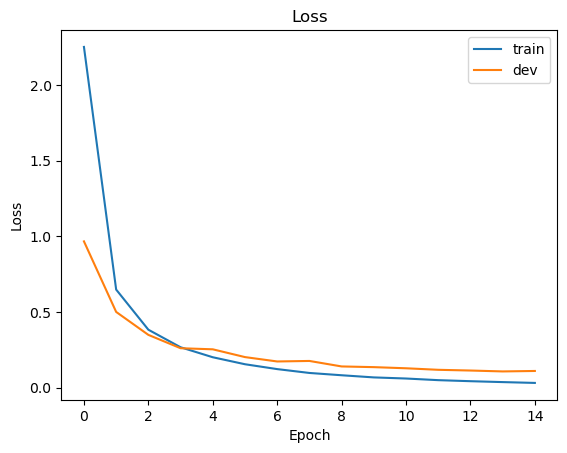

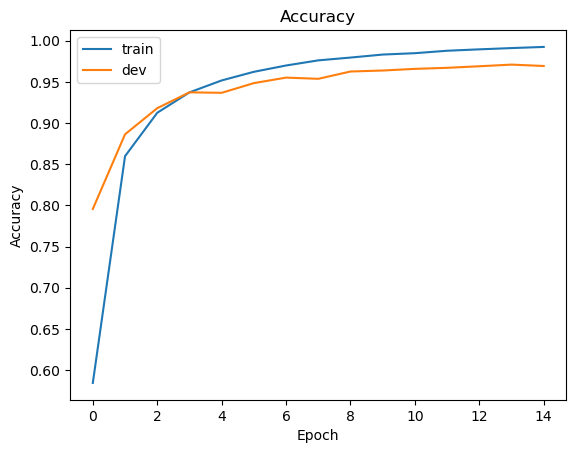

In [40]:
plt.plot(train_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='train')
plt.plot(dev_accs, label='dev')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that the model trains pretty fast and achieves over 90% validation accuracy after 2 epochs. It is also pretty stable and doesnt overfit much. It could have probably been trained with a learning rate decay schedule to achieve slightly better results.

# Evalute models

In [41]:
gru = GRUNet(
        embedding_dim=512,
        num_embeddings=len(tokenizer_dict),
        output_dim=encoder.categories_[0].shape[0],
        hidden_size=128,
        layer_num=1,
        dropout=0.1,
        bidirectional=True
    ).eval()

gru.load_state_dict(torch.load(save_path, map_location=device))

/home/jonas/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

## final accuracy score

In [42]:
eval_loss, acc, all_preds, all_ground_truths = eval_loop(
    model=gru,
    dev_loader=test_loader,
    loss_fn=torch.nn.CrossEntropyLoss(),
    epoch=0,
    device=device,
    return_predictions=True
    )

Epoch: 0, Validation Loss: 0.11264355174050882, Accuracy Score: 0.9693968177507489


The final accuracy score is roughly 0.97, which is pretty good considering that we have over 1000 classes. I was wondering how much this is due to few classes with large samples and if we have outlier classes that are hard to predict. To answer this questions I made a scatter plot that shows the number of samples per class vs the accuracy of the model on that class.

In [201]:
all_preds_domains = [encoder.categories_[0][all_preds[e]] for e in range(len(all_preds))] # name of all predicted domains
all_ground_truths_domains = [encoder.categories_[0][all_ground_truths[e]] for e in range(len(all_ground_truths))] # name of all ground truth domains
domain_counts = combined_df.groupby('family_accession').count()['sequence'].sort_values(ascending=False) # number of samples per domaim

In [229]:
accs = {'range': [], 'accuracy': [], 'range_center': []}
bin_size = 50
for cutoff in range(domain_counts.max(), 0, -bin_size):
    upper_bound = cutoff
    lower_bound = cutoff - bin_size
    domains_with_at_least_x_samples = domain_counts[(lower_bound <= domain_counts) & (domain_counts <= upper_bound)].index.values
    if len(domains_with_at_least_x_samples) == 0:
        continue
    #print(domains_with_at_least_x_samples)
    labels_idx = [idx for idx, label in enumerate(all_ground_truths_domains) if label in domains_with_at_least_x_samples]
    filtered_preds = [all_preds_domains[idx] for idx in labels_idx]
    filtered_ground_truths = [all_ground_truths_domains[idx] for idx in labels_idx]
    #print(len(filtered_preds), len(filtered_ground_truths))
    acc = accuracy_score(filtered_ground_truths, filtered_preds)
    accs['range'].append('{}-{}'.format(lower_bound, upper_bound))
    accs['accuracy'].append(acc)
    accs['range_center'].append((upper_bound + lower_bound) / 2)

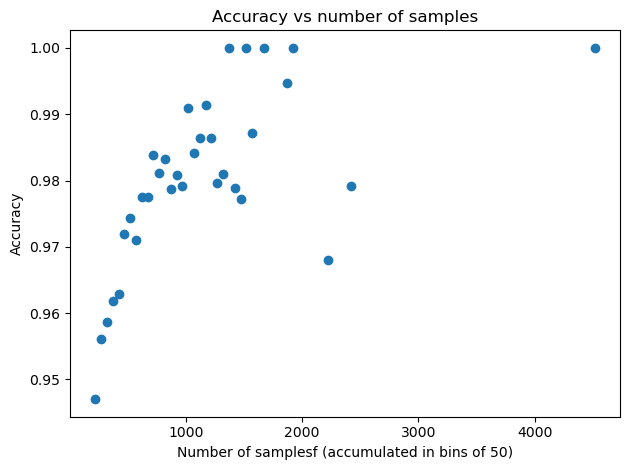

In [230]:
accs_df = pd.DataFrame(accs)

plt.scatter(accs_df['range_center'], accs_df['accuracy'])
plt.title('Accuracy vs number of samples')
plt.xlabel(f'Number of samplesf (accumulated in bins of {bin_size})')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()
# -> the more samples a domain has, the better the model performs on it
# less frequent domains still perform well (accuracy > 0.9)

We can see that there is a clear relationship between the number of samples and the accuracy. But overall even the smaller classes can be predicted relatively well.

# get embeddings and compare to Blosum62

I was interested in what the model learns and if the embeddings capture some biology. So I followed the original paper from Bileschi et al. and compared the embeddings to the Blosum62 matrix. That is an substitution matrix that is used to score alignments of amino acid sequences. It is based on the frequency of substitutions in a large set of alignments. (https://en.wikipedia.org/wiki/BLOSUM)

In [102]:
import blosum as bl
matrix = bl.BLOSUM(62)

aa_names = [tokenizer_dict.keys()]
aa_ids = [value for value in tokenizer_dict.values()]

order = ['C', 'G', 'A', 'T', 'S', 'N', 'D', 'E', 'Q', 'K', 'R', 'V', 'I', 'L', 'M', 'W', 'F', 'Y', 'P', 'H']
order_ids = [tokenizer_dict[aa] for aa in order]

blosum62 = np.zeros((len(order), len(order)))
for i, aa1 in enumerate(order):
    for e, aa2 in enumerate(order):
        blosum62[i, e] = matrix[aa1][aa2]

with torch.no_grad():
    aa_embeddings_gru = gru.embedding(torch.tensor(order_ids).long().to(device)).cpu().numpy()

Pearson correlation between GRUNet embeddings and BLOSUM62 matrix: 0.79 (p=0.000)


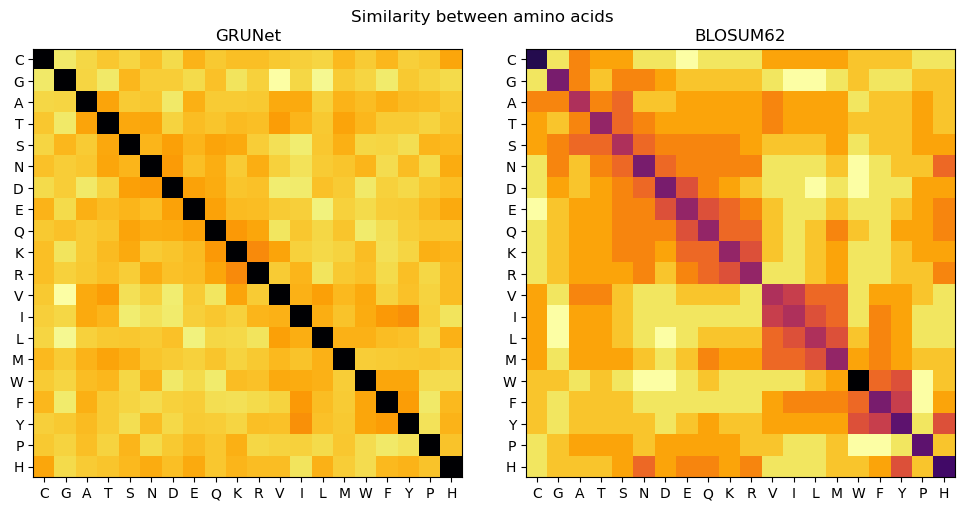

In [117]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

gru_similarity = cosine_similarity(aa_embeddings_gru)

pearson_corr = pearsonr(gru_similarity.flatten(), blosum62.flatten())[0]
pearson_p_value = pearsonr(gru_similarity.flatten(), blosum62.flatten())[1]

print('Pearson correlation between GRUNet embeddings and BLOSUM62 matrix: {:.2f} (p={:.3f})'.format(pearson_corr, np.round(pearson_p_value, 3)))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(gru_similarity, cmap='inferno_r', interpolation='none')
axs[0].set_title('GRUNet')
axs[0].set_yticks(np.arange(len(order)))
axs[0].set_yticklabels(order)
axs[0].set_xticks(np.arange(len(order)))
axs[0].set_xticklabels(order)
axs[1].imshow(blosum62, cmap='inferno_r', interpolation='none')
axs[1].set_title('BLOSUM62')
axs[1].set_yticks(np.arange(len(order)))
axs[1].set_yticklabels(order)
axs[1].set_xticks(np.arange(len(order)))
axs[1].set_xticklabels(order)
# add colorbar
plt.suptitle('Similarity between amino acids')
plt.tight_layout()
plt.show()

# -> GRUNet embeddings are correlated with Blosum62 matrix
# -> capture biological amino acid similarity to some extent

We can see that the embedding matrix is somewhat similar to the Blosum62 matrix but not as clear as in the original paper. It is clearly correlated (pearson correlation of 0.79). Interestingly when I tried to train a model that simply averages the embeddings, the resulting embedding similarities were much closer to the Blosum62 matrix. I am not sure why that is the case. Maybe the GRU is more complex and learns some other things that are not captured by the Blosum62 matrix.

# UMAP of sequence embeddings

The last step was to visualize the dataset in a 2D space. I used PCA and UMAP (https://umap-learn.readthedocs.io/en/latest/) for that. UMAP is a dimensionality reduction technique that is similar to t-SNE but faster and more robust (opinions vary). I used the hidden state of the GRU from a whole sequence as input and colored the points by the domain. In the PCA, there are a seperation but it looked very clumped together so I didn't spend more time to color the plot. Compared to that, in the UMAP there seems to be a clustering in domains and super domains. It would be interesting if closely related domains actually cluster together. I didnt have time to look into that but it would be a nice follow up (I am almost sure that someone has done that already though).

In [51]:
gru = GRUNet(
        embedding_dim=512,
        num_embeddings=len(tokenizer_dict),
        output_dim=encoder.categories_[0].shape[0],
        hidden_size=128,
        layer_num=1,
        dropout=0.1,
        bidirectional=True,
        return_embedding=True
    ).eval().to(device)

gru.load_state_dict(torch.load('../finetuned_models/GRUNet.pth', map_location=device))

/home/jonas/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [52]:
def embed_dataset(model, dataset, device):
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch_idx, (seq, label) in enumerate(dataset):
            seq = seq.to(device)
            label = label.squeeze().to(device)
            output, hn = model(seq)
            embeddings.append(hn.cpu().detach().numpy())
            labels.append(label.cpu().detach().numpy())
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

In [53]:
embeddings, labels = embed_dataset(gru, test_loader, device)

In [64]:
domain_accessions = encoder.inverse_transform(labels)

## PCA

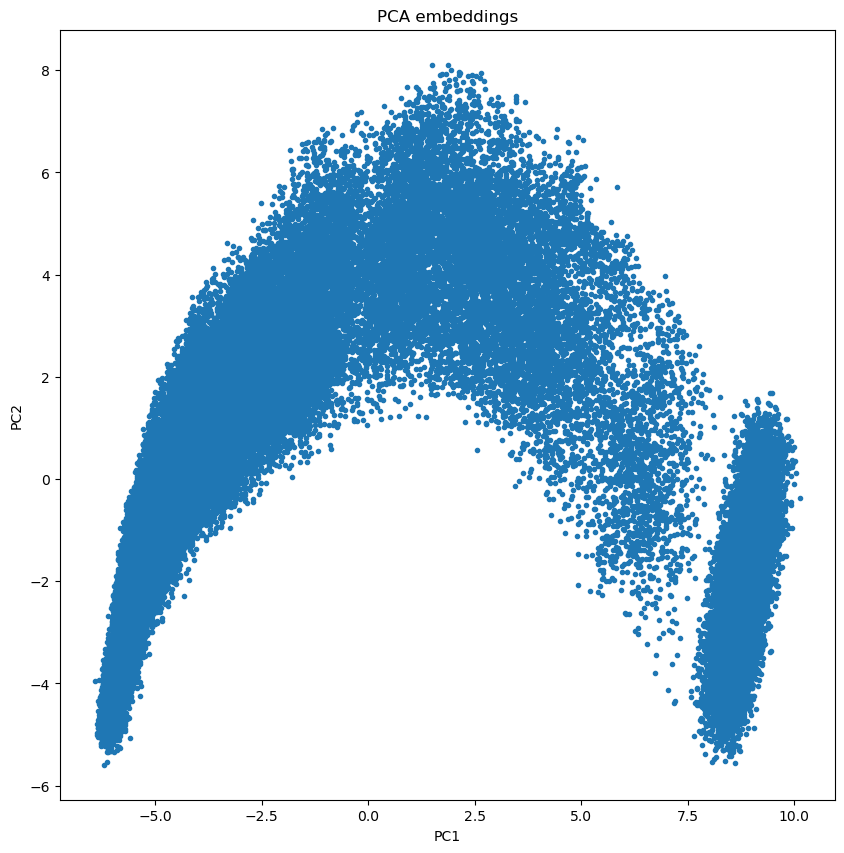

In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(embeddings)

pca_embeddings = pca.transform(embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], marker='.')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA embeddings')
plt.show()

# -> not much to see here, 

## UMAP

In [66]:
import umap
import umap.plot

mapper = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit(embeddings)

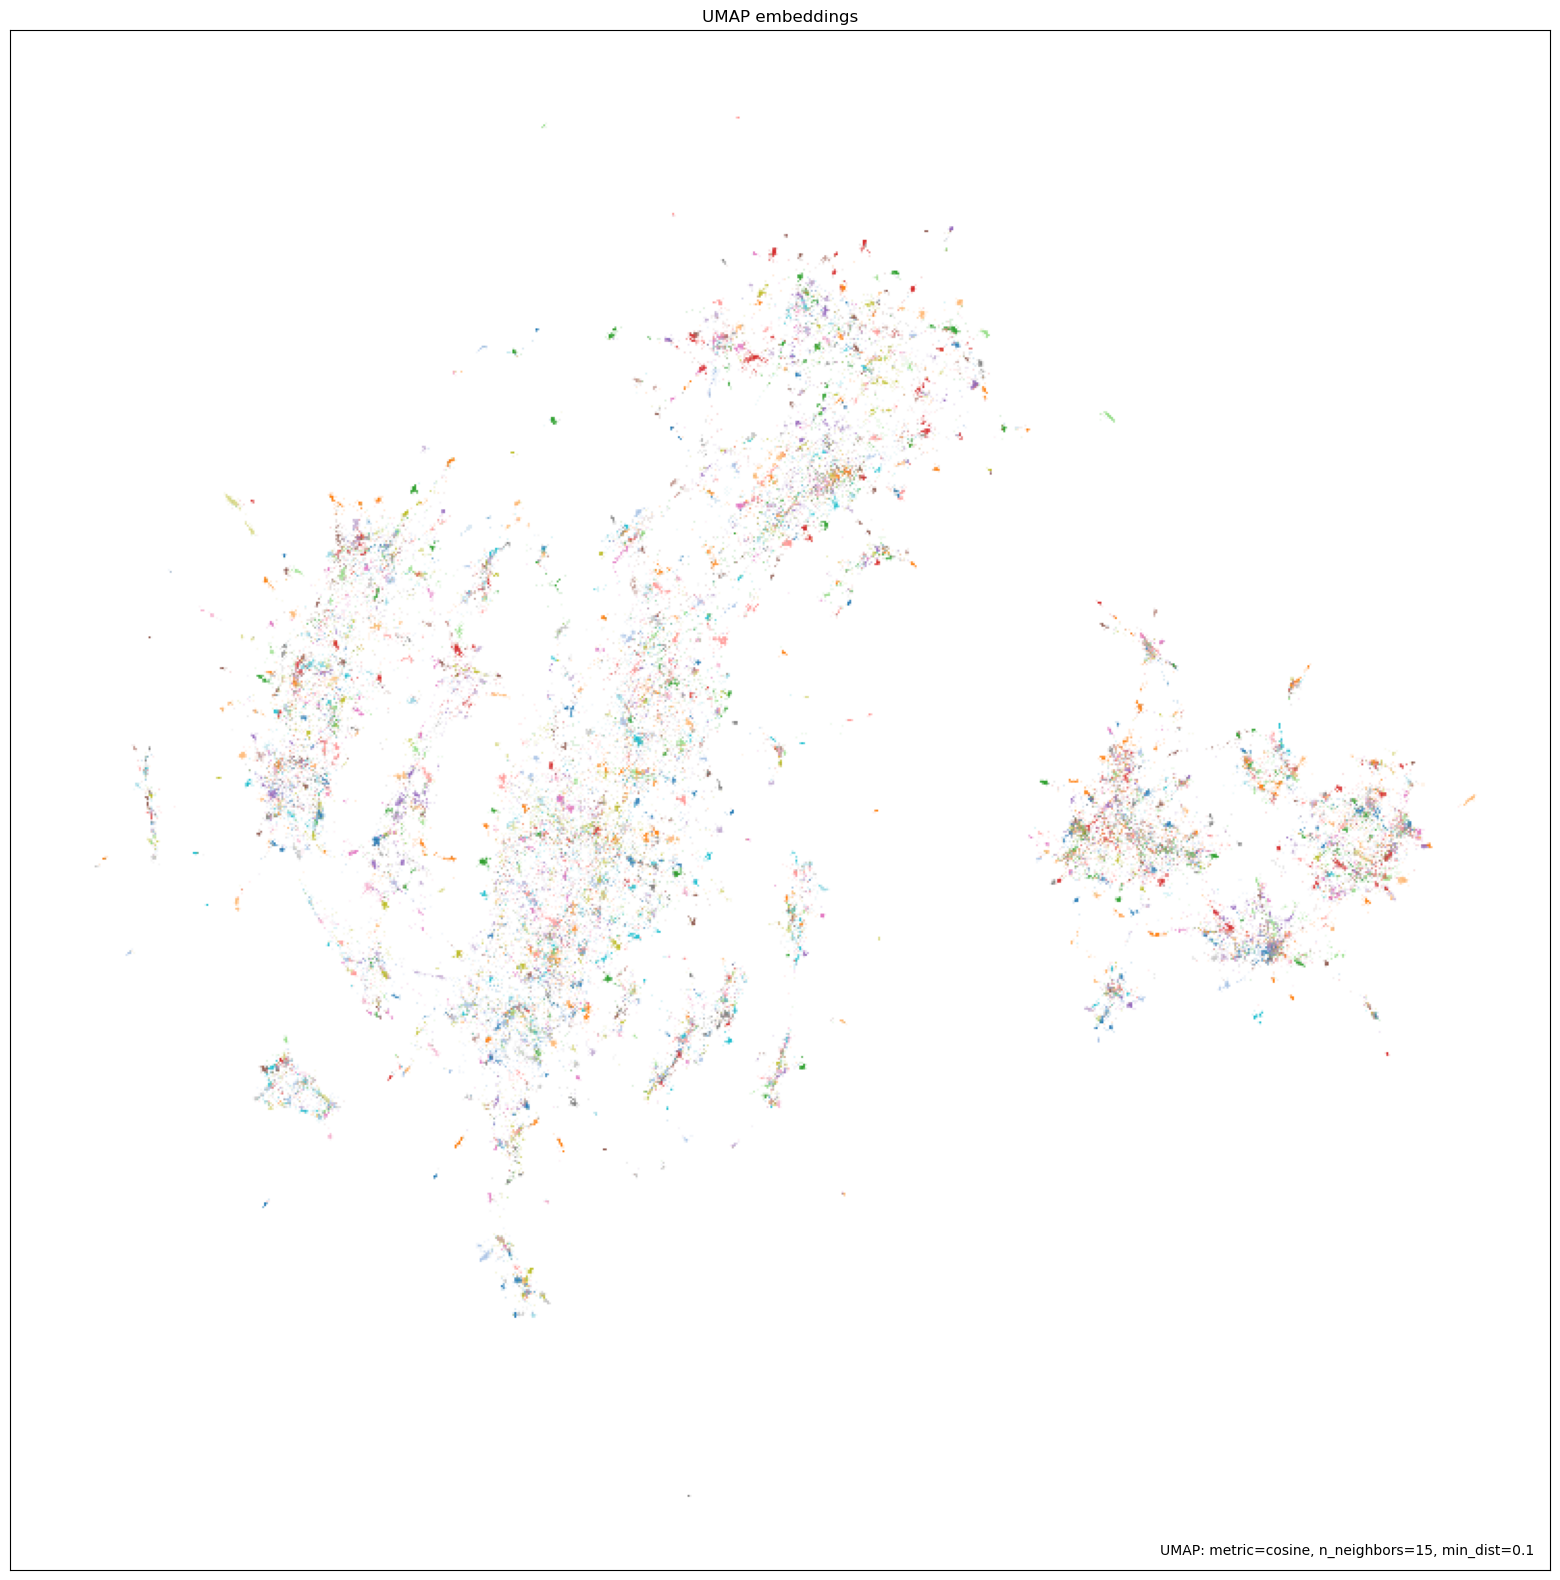

In [68]:
plt.figure(figsize=(20, 20))
umap.plot.points(mapper, labels=domain_accessions.squeeze(), ax=plt.gca(), theme='blue', show_legend=False)
plt.title('UMAP embeddings')
plt.show()
# looks pretty but needs a lot of annotations to be useful